In [1]:
import utils
import models
import executor
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import pandas as pd
from utils import perfect_square_acc

In [2]:
# load your data here. The following ensure this will work on Windows as well as Unix
path = Path("..") / "data_files" / "ecq_sha_B_50_conds_1_8191.parquet"
df = utils.load_data(path)

Loaded the dataset with 61 features and 52710 curves..


In [3]:
df = utils.process_kodaira_symbol(df)
df.drop('lmfdb_label', axis=1, inplace=True)

c:\Users\Xiaoyu Huang\Documents\ml_rnt\notebooks\utils.py:446: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_dummies = df_dummies.sum(level=0)


In [4]:
# to get a balanced dataset with equal amount of 1 and 4 labels
len_4 = df[df['sha'] == 4].shape[0]
df_balanced = df[df['sha'] == 1].sample(len_4) 
df_balanced = pd.concat([df_balanced, df[df['sha'] == 4]])
df_balanced.sha.value_counts()

1    1407
4    1407
Name: sha, dtype: int64

In [5]:
# choose model parameters
hidden_units = [10]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_balanced, 'sha', if_regression=True)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 68 and the output dimension is 1.
Device: cpu.
The model has 701 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=68, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [6]:
# choose training parameters
loss_func = nn.MSELoss()
num_epochs = 300
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = perfect_square_acc

Save the model from epoch 292 with perfect_square_acc 0.7566607460035524 to ..\trained_models\model.pth


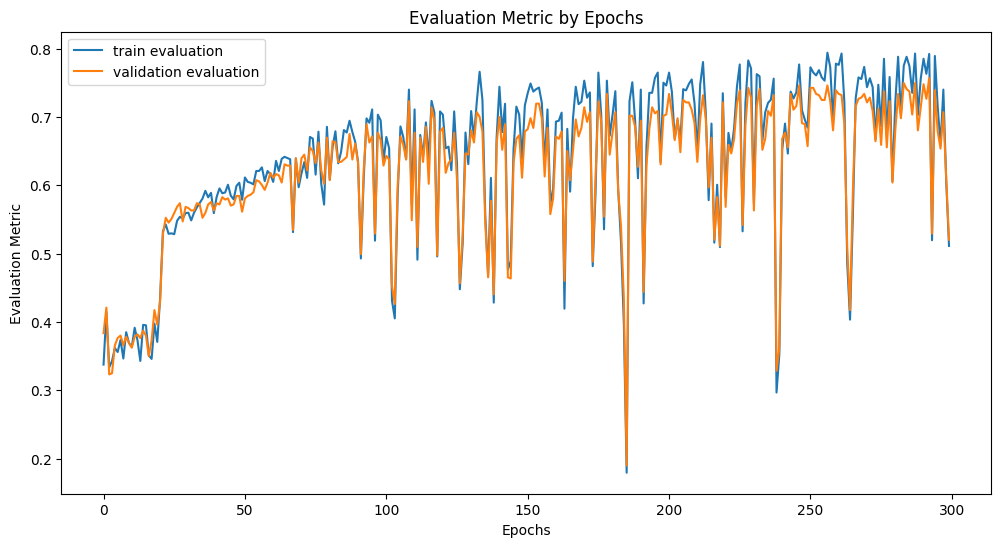

In [7]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_balanced, 'sha', device, if_regression=True)
# train the model
model, train_eval_hist, val_eval_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=True, verbose=False)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

In [8]:
# test the model
test_res = executor.test(model, test_dataset, evaluator, verbose=True, if_regression=True)

Test perfect_square_acc: 0.7708703374777975
